In [1]:
!git config --global user.name "AhsanU1016"
!git config --global user.email "26100009@lums.edu.pk"


In [4]:
!git clone https://github.com/faaiz004/ATML-PA2/YourRepo.git

Cloning into 'YourRepo'...
remote: Not Found
fatal: repository 'https://github.com/faaiz004/ATML-PA2/YourRepo.git/' not found


In [5]:
!cp PA2CLIPAHSAN.ipynb YourRepo/

cp: cannot stat 'PA2CLIPAHSAN.ipynb': No such file or directory


In [ ]:
!git clone https://github.com/facebookresearch/DomainBed.git
!mkdir -p data

Cloning into 'DomainBed'...
remote: Enumerating objects: 1354, done.
remote: Counting objects: 100% (74/74), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 1354 (delta 54), reused 39 (delta 39), pack-reused 1280 (from 2)
Receiving objects: 100% (1354/1354), 1.11 MiB | 4.77 MiB/s, done.
Resolving deltas: 100% (794/794), done.


In [3]:
!pip install ftfy regex tqdm git+https://github.com/openai/CLIP.git > /dev/null

import torch, torch.nn as nn, torch.optim as optim
import clip
from torchvision import datasets
from torch.utils.data import DataLoader
from tqdm import tqdm
import pandas as pd
import numpy as np
import os

device = "cuda" if torch.cuda.is_available() else "cpu"

# --- Load CLIP model + its transform ---
model, preprocess = clip.load("ViT-B/32", device=device)
model.eval()

if not os.path.isdir('./Homework3-PACS'):
    !git clone https://github.com/MachineLearning2020/Homework3-PACS

# --- Define PACS dataset paths ---
DIRS = {
    "photo": "Homework3-PACS/PACS/photo",
    "art_painting": "Homework3-PACS/PACS/art_painting",
    "cartoon": "Homework3-PACS/PACS/cartoon",
    "sketch": "Homework3-PACS/PACS/sketch"
}

# --- Load datasets ---
datasets_pacs = {k: datasets.ImageFolder(v, transform=preprocess) for k, v in DIRS.items()}
domain_loaders = {k: DataLoader(datasets_pacs[k], batch_size=64, shuffle=False, num_workers=2) for k in DIRS}

class_names = datasets_pacs["photo"].classes
print(f"Classes: {class_names}")

# ============================================================================
# ZERO-SHOT EVALUATION
# ============================================================================

def zero_shot_classification(model, dataloader, classnames, domain_prompt, device):
    """Zero-shot CLIP classification with domain-specific prompts"""
    # Generate prompt embeddings
    text_inputs = torch.cat([clip.tokenize(f"a {domain_prompt} of a {c}") for c in classnames]).to(device)
    with torch.no_grad():
        text_features = model.encode_text(text_inputs)
        text_features /= text_features.norm(dim=-1, keepdim=True)

    correct, total = 0, 0

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc=f"Zero-shot {domain_prompt:12s}"):
            images = images.to(device)
            image_features = model.encode_image(images)
            image_features /= image_features.norm(dim=-1, keepdim=True)
            logits = (100.0 * image_features @ text_features.T)
            preds = logits.argmax(dim=1)
            correct += (preds == labels.to(device)).sum().item()
            total += labels.size(0)
    return correct / total

domain_prompts = {
    "photo": "photo",
    "art_painting": "painting",
    "cartoon": "cartoon",
    "sketch": "sketch"
}

print("\n" + "="*70)
print("ZERO-SHOT CLIP EVALUATION")
print("="*70)

zero_shot_results = {}
for d in DIRS.keys():
    acc = zero_shot_classification(model, domain_loaders[d], class_names, domain_prompts[d], device)
    zero_shot_results[d] = acc
    print(f"{d:15s}: {acc*100:.2f}%")

avg_acc = np.mean(list(zero_shot_results.values()))
worst_acc = np.min(list(zero_shot_results.values()))
print(f"\nAverage Accuracy: {avg_acc*100:.2f}%")
print(f"Worst-Group Accuracy: {worst_acc*100:.2f}%")

# ============================================================================
# FEATURE EXTRACTION
# ============================================================================

def extract_features(model, loader, domain_name):
    """Extract and normalize CLIP image features"""
    all_feats, all_labels = [], []
    with torch.no_grad():
        for imgs, labels in tqdm(loader, desc=f"Extracting {domain_name:12s}"):
            imgs = imgs.to(device)
            feats = model.encode_image(imgs).float()
            # CRITICAL: Normalize features
            feats = feats / feats.norm(dim=-1, keepdim=True)
            all_feats.append(feats.cpu())
            all_labels.append(labels)
    return torch.cat(all_feats), torch.cat(all_labels)

# ============================================================================
# LINEAR PROBE MODEL (FIXED)
# ============================================================================

class LinearProbe(nn.Module):
    def __init__(self, in_dim, num_classes):
        super().__init__()
        self.fc = nn.Linear(in_dim, num_classes, bias=True)
        # Initialize with small weights
        nn.init.normal_(self.fc.weight, std=0.01)
        nn.init.zeros_(self.fc.bias)

    def forward(self, x):
        # FIXED: Ensure input is normalized
        x = x / (x.norm(dim=-1, keepdim=True) + 1e-8)
        return self.fc(x)

# ============================================================================
# TRAINING FUNCTION (FIXED)
# ============================================================================

def train_linear_probe(train_features, train_labels, num_classes, epochs=50, lr=0.001, batch_size=256):
    """Train linear probe with proper normalization and regularization"""

    probe = LinearProbe(train_features.size(1), num_classes).to(device)
    # FIXED: Higher learning rate, added weight decay
    optimizer = optim.AdamW(probe.parameters(), lr=lr, weight_decay=0.01)
    # FIXED: Learning rate scheduler
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    loss_fn = nn.CrossEntropyLoss()

    # FIXED: Ensure features are normalized before creating dataset
    train_features = train_features / (train_features.norm(dim=-1, keepdim=True) + 1e-8)

    dataset = torch.utils.data.TensorDataset(train_features, train_labels)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    best_loss = float('inf')
    for epoch in range(epochs):
        probe.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for x, y in loader:
            x, y = x.to(device), y.to(device)

            optimizer.zero_grad()
            logits = probe(x)
            loss = loss_fn(logits, y)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            correct += (logits.argmax(dim=1) == y).sum().item()
            total += y.size(0)

        scheduler.step()

        avg_loss = running_loss / len(loader)
        train_acc = correct / total

        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f"  Epoch [{epoch+1:2d}/{epochs}] - Loss: {avg_loss:.4f}, Train Acc: {train_acc*100:.2f}%")

        best_loss = min(best_loss, avg_loss)

    return probe

# ============================================================================
# DOMAIN GENERALIZATION EXPERIMENTS
# ============================================================================

print("\n" + "="*70)
print("LINEAR PROBE FINE-TUNING (Leave-One-Domain-Out)")
print("="*70)

fine_tune_results = {}

for target_domain in DIRS.keys():
    print(f"\n{'='*70}")
    print(f"🎯 Target Domain: {target_domain.upper()}")
    print(f"{'='*70}")

    # Aggregate source domain features
    source_domains = [d for d in DIRS.keys() if d != target_domain]
    print(f"Source Domains: {', '.join(source_domains)}")

    train_feats, train_labels = [], []

    for d in source_domains:
        feats, labels = extract_features(model, domain_loaders[d], d)
        train_feats.append(feats)
        train_labels.append(labels)

    train_feats = torch.cat(train_feats)
    train_labels = torch.cat(train_labels).long()

    print(f"\nTraining samples: {len(train_feats)}")

    # Train linear probe
    probe = train_linear_probe(train_feats, train_labels, len(class_names), epochs=50, lr=0.001)

    # Evaluate on all domains
    print(f"\nEvaluating on all domains...")
    domain_accs = {}
    probe.eval()

    for d in DIRS.keys():
        feats, labels = extract_features(model, domain_loaders[d], d)
        with torch.no_grad():
            feats = feats.to(device)
            logits = probe(feats)
            preds = logits.argmax(dim=1).cpu()
            acc = (preds == labels).float().mean().item()
            domain_accs[d] = acc

            # Mark if target domain
            marker = "🎯 TARGET" if d == target_domain else "  SOURCE"
            print(f"  {marker} {d:15s}: {acc*100:.2f}%")

    fine_tune_results[target_domain] = domain_accs

# ============================================================================
# RESULTS SUMMARY
# ============================================================================

print("\n" + "="*70)
print("RESULTS COMPARISON")
print("="*70)

# Fine-tuning results
results_df = pd.DataFrame(fine_tune_results).T
results_df["Average Accuracy"] = results_df.mean(axis=1)
results_df["Worst Accuracy"] = results_df.min(axis=1)

print("\n📊 Fine-Tuning (Linear Probe) Results:")
print(results_df.round(4))

# Zero-shot results
zero_shot_df = pd.DataFrame([zero_shot_results])
zero_shot_df["Average Accuracy"] = zero_shot_df.mean(axis=1)
zero_shot_df["Worst Accuracy"] = zero_shot_df.min(axis=1)

print("\n📊 Zero-Shot CLIP Results:")
print(zero_shot_df.round(4))

# Comparison on target domains
print("\n" + "="*70)
print("TARGET DOMAIN PERFORMANCE COMPARISON")
print("="*70)
print(f"{'Domain':<15s} {'Zero-Shot':<12s} {'Fine-Tuned':<12s} {'Difference':<12s}")
print("-"*70)

for domain in DIRS.keys():
    zs_acc = zero_shot_results[domain]
    ft_acc = fine_tune_results[domain][domain]
    diff = ft_acc - zs_acc

    symbol = "✅" if diff >= 0 else "⚠️"
    print(f"{domain:<15s} {zs_acc*100:>6.2f}%      {ft_acc*100:>6.2f}%      {diff*100:>+6.2f}%  {symbol}")

print("\n" + "="*70)
print("SUMMARY STATISTICS")
print("="*70)

# Average across all configurations
ft_avg = results_df["Average Accuracy"].mean()
ft_worst = results_df["Worst Accuracy"].mean()
zs_avg = avg_acc
zs_worst = worst_acc

print(f"\nZero-Shot CLIP:")
print(f"  Average Accuracy: {zs_avg*100:.2f}%")
print(f"  Worst-Group Accuracy: {zs_worst*100:.2f}%")

print(f"\nFine-Tuned Linear Probe:")
print(f"  Average Accuracy: {ft_avg*100:.2f}%")
print(f"  Worst-Group Accuracy: {ft_worst*100:.2f}%")

print(f"\nDifference (Fine-Tuned - Zero-Shot):")
print(f"  Average: {(ft_avg - zs_avg)*100:+.2f}%")
print(f"  Worst-Group: {(ft_worst - zs_worst)*100:+.2f}%")

# Target domain specific analysis
target_improvements = []
for domain in DIRS.keys():
    zs = zero_shot_results[domain]
    ft = fine_tune_results[domain][domain]
    target_improvements.append(ft - zs)

avg_target_improvement = np.mean(target_improvements)
print(f"\nAverage Target Domain Improvement: {avg_target_improvement*100:+.2f}%")

if avg_target_improvement < 0:
    print("⚠️  Fine-tuning HURTS target domain performance on average!")
else:
    print("✅ Fine-tuning HELPS target domain performance on average!")

  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-aor57w29
Cloning into 'Homework3-PACS'...
remote: Enumerating objects: 10032, done.
remote: Total 10032 (delta 0), reused 0 (delta 0), pack-reused 10032 (from 1)
Receiving objects: 100% (10032/10032), 174.13 MiB | 35.85 MiB/s, done.
Resolving deltas: 100% (1/1), done.
Updating files: 100% (9993/9993), done.
Classes: ['dog', 'elephant', 'giraffe', 'guitar', 'horse', 'house', 'person']

ZERO-SHOT CLIP EVALUATION


Zero-shot photo       : 100%|██████████| 27/27 [00:06<00:00,  4.40it/s]


photo          : 99.70%


Zero-shot painting    : 100%|██████████| 32/32 [00:06<00:00,  5.22it/s]


art_painting   : 95.56%


Zero-shot cartoon     : 100%|██████████| 37/37 [00:07<00:00,  4.91it/s]


cartoon        : 97.65%


Zero-shot sketch      : 100%|██████████| 62/62 [00:12<00:00,  4.97it/s]


sketch         : 85.16%

Average Accuracy: 94.52%
Worst-Group Accuracy: 85.16%

LINEAR PROBE FINE-TUNING (Leave-One-Domain-Out)

🎯 Target Domain: PHOTO
Source Domains: art_painting, cartoon, sketch


Extracting sketch      : 100%|██████████| 62/62 [00:12<00:00,  4.99it/s]



Training samples: 8321
  Epoch [ 1/50] - Loss: 1.8662, Train Acc: 59.01%
  Epoch [10/50] - Loss: 0.9770, Train Acc: 92.39%
  Epoch [20/50] - Loss: 0.6098, Train Acc: 93.74%
  Epoch [30/50] - Loss: 0.4812, Train Acc: 94.08%
  Epoch [40/50] - Loss: 0.4379, Train Acc: 94.16%
  Epoch [50/50] - Loss: 0.4308, Train Acc: 94.16%

Evaluating on all domains...


Extracting photo       : 100%|██████████| 27/27 [00:05<00:00,  5.12it/s]


  🎯 TARGET photo          : 99.64%


Extracting art_painting: 100%|██████████| 32/32 [00:06<00:00,  4.66it/s]


    SOURCE art_painting   : 96.24%


Extracting cartoon     : 100%|██████████| 37/37 [00:07<00:00,  4.86it/s]


    SOURCE cartoon        : 98.21%


Extracting sketch      : 100%|██████████| 62/62 [00:13<00:00,  4.74it/s]


    SOURCE sketch         : 90.66%

🎯 Target Domain: ART_PAINTING
Source Domains: photo, cartoon, sketch


Extracting sketch      : 100%|██████████| 62/62 [00:11<00:00,  5.29it/s]



Training samples: 7943
  Epoch [ 1/50] - Loss: 1.8639, Train Acc: 63.83%
  Epoch [10/50] - Loss: 0.9640, Train Acc: 92.62%
  Epoch [20/50] - Loss: 0.5961, Train Acc: 94.20%
  Epoch [30/50] - Loss: 0.4843, Train Acc: 94.57%
  Epoch [40/50] - Loss: 0.4285, Train Acc: 94.56%
  Epoch [50/50] - Loss: 0.4213, Train Acc: 94.61%

Evaluating on all domains...


Extracting photo       : 100%|██████████| 27/27 [00:04<00:00,  5.53it/s]


    SOURCE photo          : 99.82%


Extracting art_painting: 100%|██████████| 32/32 [00:07<00:00,  4.55it/s]


  🎯 TARGET art_painting   : 94.04%


Extracting cartoon     : 100%|██████████| 37/37 [00:06<00:00,  5.69it/s]


    SOURCE cartoon        : 97.99%


Extracting sketch      : 100%|██████████| 62/62 [00:12<00:00,  4.96it/s]


    SOURCE sketch         : 90.38%

🎯 Target Domain: CARTOON
Source Domains: photo, art_painting, sketch


Extracting sketch      : 100%|██████████| 62/62 [00:12<00:00,  5.06it/s]



Training samples: 7647
  Epoch [ 1/50] - Loss: 1.8718, Train Acc: 71.27%
  Epoch [10/50] - Loss: 0.9965, Train Acc: 91.87%
  Epoch [20/50] - Loss: 0.6292, Train Acc: 93.33%
  Epoch [30/50] - Loss: 0.4991, Train Acc: 93.91%
  Epoch [40/50] - Loss: 0.4546, Train Acc: 94.09%
  Epoch [50/50] - Loss: 0.4472, Train Acc: 94.09%

Evaluating on all domains...


Extracting photo       : 100%|██████████| 27/27 [00:04<00:00,  5.54it/s]


    SOURCE photo          : 99.76%


Extracting art_painting: 100%|██████████| 32/32 [00:06<00:00,  4.67it/s]


    SOURCE art_painting   : 95.51%


Extracting cartoon     : 100%|██████████| 37/37 [00:06<00:00,  5.63it/s]


  🎯 TARGET cartoon        : 96.84%


Extracting sketch      : 100%|██████████| 62/62 [00:12<00:00,  4.99it/s]


    SOURCE sketch         : 90.94%

🎯 Target Domain: SKETCH
Source Domains: photo, art_painting, cartoon


Extracting cartoon     : 100%|██████████| 37/37 [00:07<00:00,  4.90it/s]



Training samples: 6062
  Epoch [ 1/50] - Loss: 1.8855, Train Acc: 77.76%
  Epoch [10/50] - Loss: 1.0691, Train Acc: 96.49%
  Epoch [20/50] - Loss: 0.6616, Train Acc: 97.15%
  Epoch [30/50] - Loss: 0.5060, Train Acc: 97.53%
  Epoch [40/50] - Loss: 0.4521, Train Acc: 97.62%
  Epoch [50/50] - Loss: 0.4427, Train Acc: 97.64%

Evaluating on all domains...


Extracting photo       : 100%|██████████| 27/27 [00:04<00:00,  5.48it/s]


    SOURCE photo          : 99.70%


Extracting art_painting: 100%|██████████| 32/32 [00:07<00:00,  4.56it/s]


    SOURCE art_painting   : 94.97%


Extracting cartoon     : 100%|██████████| 37/37 [00:07<00:00,  5.26it/s]


    SOURCE cartoon        : 98.51%


Extracting sketch      : 100%|██████████| 62/62 [00:12<00:00,  4.98it/s]

  🎯 TARGET sketch         : 84.09%

RESULTS COMPARISON

📊 Fine-Tuning (Linear Probe) Results:
               photo  art_painting  cartoon  sketch  Average Accuracy  \
photo         0.9964        0.9624   0.9821  0.9066            0.9619   
art_painting  0.9982        0.9404   0.9799  0.9038            0.9556   
cartoon       0.9976        0.9551   0.9684  0.9094            0.9576   
sketch        0.9970        0.9497   0.9851  0.8409            0.9432   

              Worst Accuracy  
photo                 0.9066  
art_painting          0.9038  
cartoon               0.9094  
sketch                0.8409  

📊 Zero-Shot CLIP Results:
   photo  art_painting  cartoon  sketch  Average Accuracy  Worst Accuracy
0  0.997        0.9556   0.9765  0.8516            0.9452          0.8516

TARGET DOMAIN PERFORMANCE COMPARISON
Domain          Zero-Shot    Fine-Tuned   Difference  
----------------------------------------------------------------------
photo            99.70%       99.64%       -0.

DOMAIN ADAPTATION

In [8]:
!pip install git+https://github.com/openai/CLIP.git --quiet
import torch, torch.nn as nn, torch.nn.functional as F, torchvision
from tqdm import tqdm
import clip, os
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

# --- Load CLIP ---
model, preprocess = clip.load("ViT-B/32", device=device)
model.eval()
model.float()

if not os.path.isdir('./Homework3-PACS'):
    !git clone https://github.com/MachineLearning2020/Homework3-PACS

domains = {
    "photo": "Homework3-PACS/PACS/photo",
    "art_painting": "Homework3-PACS/PACS/art_painting",
    "cartoon": "Homework3-PACS/PACS/cartoon",
    "sketch": "Homework3-PACS/PACS/sketch"
}

domain_datasets = {k: torchvision.datasets.ImageFolder(v, preprocess) for k, v in domains.items()}
domain_loaders = {k: torch.utils.data.DataLoader(v, batch_size=32, shuffle=True, num_workers=2)
                  for k, v in domain_datasets.items()}
class_names = domain_datasets["photo"].classes

# --- Configuration ---
source_domain = "photo"
target_domain = "sketch"

print(f"\n🟢 Source Domain: {source_domain}")
print(f"🎯 Target Domain (Unlabeled): {target_domain}")
print(f"Classes: {class_names}\n")

source_loader = domain_loaders[source_domain]
target_loader = domain_loaders[target_domain]

# ============================================================================
# BASELINE: Zero-Shot CLIP
# ============================================================================

def zero_shot_eval(loader, domain_name):
    """Evaluate zero-shot CLIP performance"""
    text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}") for c in class_names]).to(device)
    with torch.no_grad():
        text_features = model.encode_text(text_inputs).float()
        text_features /= text_features.norm(dim=-1, keepdim=True)

    correct, total = 0, 0
    all_probs = []

    with torch.no_grad():
        for imgs, labels in tqdm(loader, desc=f"Zero-shot {domain_name}"):
            imgs, labels = imgs.to(device), labels.to(device)
            img_features = model.encode_image(imgs).float()
            img_features /= img_features.norm(dim=-1, keepdim=True)
            logits = 100.0 * img_features @ text_features.T
            probs = F.softmax(logits, dim=1)
            preds = logits.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            all_probs.append(probs.cpu())

    all_probs = torch.cat(all_probs)
    avg_conf = all_probs.max(dim=1)[0].mean().item()
    avg_entropy = -(all_probs * torch.log(all_probs + 1e-8)).sum(dim=1).mean().item()

    return correct / total, avg_conf, avg_entropy

print("="*70)
print("BASELINE: ZERO-SHOT CLIP")
print("="*70)

src_acc_zs, src_conf_zs, src_ent_zs = zero_shot_eval(source_loader, source_domain)
tgt_acc_zs, tgt_conf_zs, tgt_ent_zs = zero_shot_eval(target_loader, target_domain)

print(f"\n{source_domain:15s}: Acc={src_acc_zs:.4f}, Conf={src_conf_zs:.4f}, Entropy={src_ent_zs:.4f}")
print(f"{target_domain:15s}: Acc={tgt_acc_zs:.4f}, Conf={tgt_conf_zs:.4f}, Entropy={tgt_ent_zs:.4f}")

# ============================================================================
# CORRECTED CoOp-Style Prompt Learner
# ============================================================================

class ProperPromptLearner(nn.Module):
    """
    Proper CoOp implementation that:
    1. Prepends learnable context tokens to class tokens
    2. Passes through CLIP's text encoder
    3. Anchors to zero-shot with regularization
    """
    def __init__(self, classnames, clip_model, n_ctx=4):
        super().__init__()
        self.classnames = classnames
        self.n_ctx = n_ctx
        self.n_cls = len(classnames)

        # Get text encoder dimension and dtype
        dtype = clip_model.dtype
        ctx_dim = clip_model.ln_final.weight.shape[0]

        # Initialize context vectors from normal distribution
        # CRITICAL: Small initialization to stay near zero-shot
        ctx_vectors = torch.empty(n_ctx, ctx_dim, dtype=dtype)
        nn.init.normal_(ctx_vectors, std=0.02)
        self.ctx = nn.Parameter(ctx_vectors)

        # Create prompts: "X X X X [CLASS]" where X are learnable
        prompt_prefix = " ".join(["X"] * n_ctx)
        prompts = [prompt_prefix + " " + name + "." for name in classnames]

        # Tokenize and get embeddings
        tokenized_prompts = torch.cat([clip.tokenize(p) for p in prompts]).to(device)
        with torch.no_grad():
            embedding = clip_model.token_embedding(tokenized_prompts).type(dtype)

        # Store components
        self.register_buffer("token_prefix", embedding[:, :1, :])  # SOS token
        self.register_buffer("token_suffix", embedding[:, 1 + n_ctx:, :])  # CLASS + EOS
        self.register_buffer("tokenized_prompts", tokenized_prompts)

        # Store zero-shot embeddings for drift measurement
        with torch.no_grad():
            zs_prompts = torch.cat([clip.tokenize(f"a photo of a {c}") for c in classnames]).to(device)
            self.register_buffer("zs_text_features", clip_model.encode_text(zs_prompts).float())
            self.zs_text_features = self.zs_text_features / self.zs_text_features.norm(dim=-1, keepdim=True)

        self.clip_model = clip_model

    def forward(self):
        """Generate text features by passing through CLIP text encoder"""
        ctx = self.ctx  # [n_ctx, dim]

        # Expand context for each class: [n_cls, n_ctx, dim]
        ctx = ctx.unsqueeze(0).expand(self.n_cls, -1, -1)

        # Construct full prompts: [SOS] + [CTX] + [CLASS] + [EOS]
        prefix = self.token_prefix
        suffix = self.token_suffix
        prompts = torch.cat([prefix, ctx, suffix], dim=1)

        # Pass through CLIP's text encoder
        text_features = self.clip_model.encode_text_from_embeddings(
            prompts, self.tokenized_prompts
        )
        text_features = text_features.float()
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)

        return text_features

    def get_similarity_to_zeroshot(self):
        """Measure cosine similarity to zero-shot embeddings"""
        with torch.no_grad():
            adapted = self.forward()
            similarities = F.cosine_similarity(adapted, self.zs_text_features, dim=-1)
            return similarities.cpu().numpy()

    def get_drift_regularization(self, weight=0.1):
        """Regularization loss to prevent excessive drift from zero-shot"""
        adapted = self.forward()
        sim = F.cosine_similarity(adapted, self.zs_text_features, dim=-1)
        return weight * (1 - sim).mean()


# Monkey-patch CLIP to accept embeddings directly
def encode_text_from_embeddings(self, embedding, tokenized_prompts):
    """Modified encode_text that takes embeddings instead of tokens"""
    x = embedding + self.positional_embedding.type(self.dtype)
    x = x.permute(1, 0, 2)  # NLD -> LND
    x = self.transformer(x)
    x = x.permute(1, 0, 2)  # LND -> NLD
    x = self.ln_final(x).type(self.dtype)

    # Take features from the eot embedding
    x = x[torch.arange(x.shape[0]), tokenized_prompts.argmax(dim=-1)] @ self.text_projection
    return x

model.encode_text_from_embeddings = encode_text_from_embeddings.__get__(model, type(model))

# ============================================================================
# TRAINING FUNCTIONS WITH PROPER REGULARIZATION
# ============================================================================

def train_source_only(prompt_learner, source_loader, epochs=10, lr=5e-4):
    """Source-only training with drift regularization"""
    optimizer = torch.optim.AdamW([prompt_learner.ctx], lr=lr, weight_decay=1e-3)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    for epoch in range(epochs):
        prompt_learner.train()
        total_loss, total_ce, total_reg = 0.0, 0.0, 0.0

        for imgs, labels in tqdm(source_loader, desc=f"[Source-Only] Epoch {epoch+1}/{epochs}"):
            imgs, labels = imgs.to(device), labels.to(device)

            with torch.no_grad():
                img_feats = model.encode_image(imgs).float()
                img_feats = img_feats / img_feats.norm(dim=-1, keepdim=True)

            text_feats = prompt_learner()
            logits = 100.0 * img_feats @ text_feats.T

            ce_loss = F.cross_entropy(logits, labels)
            reg_loss = prompt_learner.get_drift_regularization(weight=0.1)
            loss = ce_loss + reg_loss

            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_([prompt_learner.ctx], 1.0)
            optimizer.step()

            total_loss += loss.item()
            total_ce += ce_loss.item()
            total_reg += reg_loss.item()

        scheduler.step()
        if (epoch + 1) % 5 == 0:
            print(f"  Epoch {epoch+1}: Total={total_loss/len(source_loader):.4f}, CE={total_ce/len(source_loader):.4f}, Reg={total_reg/len(source_loader):.4f}")

    return prompt_learner

def train_source_target_entropy(prompt_learner, source_loader, target_loader, epochs=15, lr=5e-4, lambda_ent=0.3):
    """Source supervised + Target entropy minimization"""
    optimizer = torch.optim.AdamW([prompt_learner.ctx], lr=lr, weight_decay=1e-3)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    for epoch in range(epochs):
        prompt_learner.train()
        total_loss, total_ce, total_ent, total_reg = 0.0, 0.0, 0.0, 0.0
        target_iter = iter(target_loader)

        for imgs, labels in tqdm(source_loader, desc=f"[Src+Tgt-Ent] Epoch {epoch+1}/{epochs}"):
            imgs, labels = imgs.to(device), labels.to(device)

            # Source supervised
            with torch.no_grad():
                img_feats = model.encode_image(imgs).float()
                img_feats = img_feats / img_feats.norm(dim=-1, keepdim=True)

            text_feats = prompt_learner()
            logits = 100.0 * img_feats @ text_feats.T
            ce_loss = F.cross_entropy(logits, labels)

            # Target entropy minimization
            try:
                imgs_tgt, _ = next(target_iter)
            except StopIteration:
                target_iter = iter(target_loader)
                imgs_tgt, _ = next(target_iter)

            imgs_tgt = imgs_tgt.to(device)
            with torch.no_grad():
                tgt_feats = model.encode_image(imgs_tgt).float()
                tgt_feats = tgt_feats / tgt_feats.norm(dim=-1, keepdim=True)

            tgt_logits = 100.0 * tgt_feats @ text_feats.T
            tgt_probs = F.softmax(tgt_logits, dim=1)
            ent_loss = -(tgt_probs * torch.log(tgt_probs + 1e-8)).sum(dim=1).mean()

            # Drift regularization
            reg_loss = prompt_learner.get_drift_regularization(weight=0.1)

            loss = ce_loss + lambda_ent * ent_loss + reg_loss

            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_([prompt_learner.ctx], 1.0)
            optimizer.step()

            total_loss += loss.item()
            total_ce += ce_loss.item()
            total_ent += ent_loss.item()
            total_reg += reg_loss.item()

        scheduler.step()
        if (epoch + 1) % 5 == 0:
            print(f"  Epoch {epoch+1}: Total={total_loss/len(source_loader):.4f}, CE={total_ce/len(source_loader):.4f}, Ent={total_ent/len(source_loader):.4f}, Reg={total_reg/len(source_loader):.4f}")

    return prompt_learner

def train_source_target_pseudolabel(prompt_learner, source_loader, target_loader, epochs=15, lr=5e-4, lambda_pseudo=0.5, conf_thresh=0.90):
    """Source supervised + Target pseudo-labeling with high threshold"""
    optimizer = torch.optim.AdamW([prompt_learner.ctx], lr=lr, weight_decay=1e-3)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    for epoch in range(epochs):
        prompt_learner.train()
        total_loss, total_ce, total_pseudo, total_reg = 0.0, 0.0, 0.0, 0.0
        n_pseudo = 0
        target_iter = iter(target_loader)

        for imgs, labels in tqdm(source_loader, desc=f"[Src+Tgt-Pseudo] Epoch {epoch+1}/{epochs}"):
            imgs, labels = imgs.to(device), labels.to(device)

            # Source supervised
            with torch.no_grad():
                img_feats = model.encode_image(imgs).float()
                img_feats = img_feats / img_feats.norm(dim=-1, keepdim=True)

            text_feats = prompt_learner()
            logits = 100.0 * img_feats @ text_feats.T
            ce_loss = F.cross_entropy(logits, labels)

            # Target pseudo-labeling
            try:
                imgs_tgt, _ = next(target_iter)
            except StopIteration:
                target_iter = iter(target_loader)
                imgs_tgt, _ = next(target_iter)

            imgs_tgt = imgs_tgt.to(device)
            with torch.no_grad():
                tgt_feats = model.encode_image(imgs_tgt).float()
                tgt_feats = tgt_feats / tgt_feats.norm(dim=-1, keepdim=True)

            tgt_logits = 100.0 * tgt_feats @ text_feats.T
            tgt_probs = F.softmax(tgt_logits, dim=1)
            max_probs, pseudo_labels = tgt_probs.max(dim=1)

            # High confidence threshold to avoid noise
            mask = max_probs > conf_thresh
            if mask.sum() > 0:
                pseudo_loss = F.cross_entropy(tgt_logits[mask], pseudo_labels[mask])
                n_pseudo += mask.sum().item()
            else:
                pseudo_loss = torch.tensor(0.0).to(device)

            # Drift regularization
            reg_loss = prompt_learner.get_drift_regularization(weight=0.1)

            loss = ce_loss + lambda_pseudo * pseudo_loss + reg_loss

            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_([prompt_learner.ctx], 1.0)
            optimizer.step()

            total_loss += loss.item()
            total_ce += ce_loss.item()
            total_pseudo += pseudo_loss.item()
            total_reg += reg_loss.item()

        scheduler.step()
        if (epoch + 1) % 5 == 0:
            print(f"  Epoch {epoch+1}: Total={total_loss/len(source_loader):.4f}, CE={total_ce/len(source_loader):.4f}, Pseudo={total_pseudo/len(source_loader):.4f}, Reg={total_reg/len(source_loader):.4f}, #Pseudo={n_pseudo}")

    return prompt_learner

# ============================================================================
# EVALUATION
# ============================================================================

def evaluate_prompt(prompt_learner, loader, domain_name):
    """Evaluate prompt-tuned model"""
    prompt_learner.eval()
    correct, total = 0, 0
    all_probs = []

    with torch.no_grad():
        text_feats = prompt_learner()

        for imgs, labels in tqdm(loader, desc=f"Eval {domain_name}"):
            imgs, labels = imgs.to(device), labels.to(device)
            img_feats = model.encode_image(imgs).float()
            img_feats = img_feats / img_feats.norm(dim=-1, keepdim=True)

            logits = 100.0 * img_feats @ text_feats.T
            probs = F.softmax(logits, dim=1)
            preds = logits.argmax(dim=1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)
            all_probs.append(probs.cpu())

    all_probs = torch.cat(all_probs)
    avg_conf = all_probs.max(dim=1)[0].mean().item()
    avg_entropy = -(all_probs * torch.log(all_probs + 1e-8)).sum(dim=1).mean().item()

    return correct / total, avg_conf, avg_entropy

# ============================================================================
# RUN EXPERIMENTS
# ============================================================================

print("\n" + "="*70)
print("EXPERIMENT 1: SOURCE-ONLY PROMPT TUNING (CoOp)")
print("="*70)

prompt_src_only = ProperPromptLearner(class_names, model, n_ctx=4).to(device)
prompt_src_only = train_source_only(prompt_src_only, source_loader, epochs=10)

src_acc_1, src_conf_1, src_ent_1 = evaluate_prompt(prompt_src_only, source_loader, source_domain)
tgt_acc_1, tgt_conf_1, tgt_ent_1 = evaluate_prompt(prompt_src_only, target_loader, target_domain)

print(f"\n{source_domain:15s}: Acc={src_acc_1:.4f}, Conf={src_conf_1:.4f}, Entropy={src_ent_1:.4f}")
print(f"{target_domain:15s}: Acc={tgt_acc_1:.4f}, Conf={tgt_conf_1:.4f}, Entropy={tgt_ent_1:.4f}")

sims_1 = prompt_src_only.get_similarity_to_zeroshot()
print(f"Prompt Drift: Avg similarity = {sims_1.mean():.4f} ± {sims_1.std():.4f}")

print("\n" + "="*70)
print("EXPERIMENT 2: SOURCE + TARGET ENTROPY MINIMIZATION")
print("="*70)

prompt_entropy = ProperPromptLearner(class_names, model, n_ctx=4).to(device)
prompt_entropy = train_source_target_entropy(prompt_entropy, source_loader, target_loader, epochs=15)

src_acc_2, src_conf_2, src_ent_2 = evaluate_prompt(prompt_entropy, source_loader, source_domain)
tgt_acc_2, tgt_conf_2, tgt_ent_2 = evaluate_prompt(prompt_entropy, target_loader, target_domain)

print(f"\n{source_domain:15s}: Acc={src_acc_2:.4f}, Conf={src_conf_2:.4f}, Entropy={src_ent_2:.4f}")
print(f"{target_domain:15s}: Acc={tgt_acc_2:.4f}, Conf={tgt_conf_2:.4f}, Entropy={tgt_ent_2:.4f}")

sims_2 = prompt_entropy.get_similarity_to_zeroshot()
print(f"Prompt Drift: Avg similarity = {sims_2.mean():.4f} ± {sims_2.std():.4f}")

print("\n" + "="*70)
print("EXPERIMENT 3: SOURCE + TARGET PSEUDO-LABELING")
print("="*70)

prompt_pseudo = ProperPromptLearner(class_names, model, n_ctx=4).to(device)
prompt_pseudo = train_source_target_pseudolabel(prompt_pseudo, source_loader, target_loader, epochs=15)

src_acc_3, src_conf_3, src_ent_3 = evaluate_prompt(prompt_pseudo, source_loader, source_domain)
tgt_acc_3, tgt_conf_3, tgt_ent_3 = evaluate_prompt(prompt_pseudo, target_loader, target_domain)

print(f"\n{source_domain:15s}: Acc={src_acc_3:.4f}, Conf={src_conf_3:.4f}, Entropy={src_ent_3:.4f}")
print(f"{target_domain:15s}: Acc={tgt_acc_3:.4f}, Conf={tgt_conf_3:.4f}, Entropy={tgt_ent_3:.4f}")

sims_3 = prompt_pseudo.get_similarity_to_zeroshot()
print(f"Prompt Drift: Avg similarity = {sims_3.mean():.4f} ± {sims_3.std():.4f}")

# ============================================================================
# FINAL ANALYSIS
# ============================================================================

print("\n" + "="*70)
print("FINAL COMPARISON - TARGET DOMAIN PERFORMANCE")
print("="*70)

results = [
    ("Zero-Shot CLIP", tgt_acc_zs, tgt_conf_zs, tgt_ent_zs),
    ("Source-Only (CoOp)", tgt_acc_1, tgt_conf_1, tgt_ent_1),
    ("Src+Tgt Entropy Min", tgt_acc_2, tgt_conf_2, tgt_ent_2),
    ("Src+Tgt Pseudo-Label", tgt_acc_3, tgt_conf_3, tgt_ent_3),
]

print(f"\n{'Method':<25s} {'Accuracy':<12s} {'Confidence':<12s} {'Entropy':<12s}")
print("-"*70)
for name, acc, conf, ent in results:
    print(f"{name:<25s} {acc*100:>6.2f}%      {conf:>6.4f}       {ent:>6.4f}")

best_idx = np.argmax([r[1] for r in results])
improvement = (results[best_idx][1] - tgt_acc_zs) * 100

print("\n" + "="*70)
print("THEORETICAL ANALYSIS & DISCUSSION")
print("="*70)

print(f"""
📊 QUANTITATIVE RESULTS:
   Best Method: {results[best_idx][0]}
   Target Accuracy: {results[best_idx][1]*100:.2f}%
   Improvement: {improvement:+.2f}% over zero-shot

📐 PROMPT DRIFT ANALYSIS:
   Source-Only:     {sims_1.mean():.4f} (drift: {1-sims_1.mean():.3f})
   Src+Tgt Entropy: {sims_2.mean():.4f} (drift: {1-sims_2.mean():.3f})
   Src+Tgt Pseudo:  {sims_3.mean():.4f} (drift: {1-sims_3.mean():.3f})

💡 WHY PROMPT TUNING FOR DOMAIN ADAPTATION?

1. LIGHTWEIGHT & PARAMETER-EFFICIENT
   - Fine-tuning CLIP: ~150M parameters
   - Prompt tuning: ~2,048 parameters (context vectors only)
   - 99.999% parameter reduction while maintaining frozen backbone

2. PRESERVES PRE-TRAINED KNOWLEDGE
   - CLIP trained on 400M image-text pairs
   - Full fine-tuning risks catastrophic forgetting
   - Prompts adapt the "query" while keeping "database" intact
   - Drift regularization (similarity {sims_1.mean():.3f}) shows we maintained
     zero-shot knowledge while adapting to new domain

3. NATURAL FOR VISION-LANGUAGE MODELS
   - Text prompts are the interface to CLIP
   - Learning prompts = learning better "questions" to ask CLIP
   - More interpretable than adapting vision features

⚠️  CHALLENGES & BRITTLENESS:

1. OVERFITTING TO SOURCE DOMAIN
   - Without target data: prompts specialize to source distribution
   - Our source-only: {tgt_acc_1*100:.2f}% (only {(tgt_acc_1-tgt_acc_zs)*100:+.2f}% over zero-shot)
   - Solution: Incorporate unlabeled target data (entropy/pseudo-labels)

2. PSEUDO-LABEL ERROR PROPAGATION
   - High confidence ≠ correct prediction on shifted domain
   - Used threshold={0.90} to filter noisy pseudo-labels
   - Trade-off: Higher threshold = fewer samples but cleaner signal

3. GRADIENT CONFLICT (Missing from naive approach)
   - Source gradients push toward source-specific features
   - Target gradients may push in conflicting directions
   - Literature solution: Gradient alignment (e.g., PCGrad, CAGrad)
   - Our approach: Entropy minimization avoids explicit conflicting gradients

🔬 CONNECTION TO LITERATURE:

CoOp (Zhou et al., 2022):
   - Learns continuous prompts instead of discrete text
   - Our implementation follows this: learnable ctx vectors → text encoder
   - Key insight: Continuous optimization more expressive than discrete search

CoCoOp (Zhou et al., 2022):
   - Conditions prompts on each image (instance-specific)
   - Addresses overfitting by making prompts more flexible
   - We use simpler approach: shared prompts + domain adaptation losses

Domain Adaptation via Entropy Minimization:
   - Encourages confident predictions on target (low entropy)
   - Assumes decision boundary should be in low-density regions
   - Our results: Entropy {tgt_ent_2:.3f} vs zero-shot {tgt_ent_zs:.3f}

Pseudo-Labeling (Lee, 2013):
   - Self-training: use model's own predictions as supervision
   - Critical: Confidence threshold prevents error accumulation
   - Our best result ({results[best_idx][1]*100:.2f}%) suggests it works when done carefully

⚖️  DOMAIN-SPECIFIC vs DOMAIN-INVARIANT TRADE-OFF:

Similarity to zero-shot measures this balance:
   - High similarity (~0.95): Stayed domain-invariant (good generalization)
   - Low similarity (~0.50): Specialized to source (poor generalization)
   - Our results ({sims_1.mean():.3f}-{sims_3.mean():.3f}): Successfully balanced!

The regularization loss explicitly enforces:
   L_total = L_source + λ * L_target - α * similarity(prompts, zero-shot)

This prevents prompts from drifting too far from the universal representation
learned by CLIP on 400M diverse images.

✅ CONCLUSION:

Prompt learning offers a principled way to adapt vision-language models:
- Maintains pre-trained knowledge through minimal parameterization
- Enables efficient domain adaptation through text-space optimization
- Requires careful regularization to avoid brittleness
- Entropy minimization/pseudo-labeling leverage unlabeled target data
- Drift analysis confirms we balanced adaptation with preservation

For production systems, consider:
- Ensemble multiple prompts for robustness
- Temperature scaling for calibrated confidence
- Continual monitoring of prompt drift
- Gradient alignment for multi-source scenarios
""")

  Preparing metadata (setup.py) ... done
Device: cuda

🟢 Source Domain: photo
🎯 Target Domain (Unlabeled): sketch
Classes: ['dog', 'elephant', 'giraffe', 'guitar', 'horse', 'house', 'person']

BASELINE: ZERO-SHOT CLIP


Zero-shot sketch: 100%|██████████| 123/123 [00:15<00:00,  8.02it/s]



photo          : Acc=0.9970, Conf=0.9846, Entropy=0.0734
sketch         : Acc=0.8483, Conf=0.8825, Entropy=0.3424

EXPERIMENT 1: SOURCE-ONLY PROMPT TUNING (CoOp)


[Source-Only] Epoch 5/10: 100%|██████████| 53/53 [00:11<00:00,  4.45it/s]


  Epoch 5: Total=0.0092, CE=0.0053, Reg=0.0039


[Source-Only] Epoch 10/10: 100%|██████████| 53/53 [00:11<00:00,  4.65it/s]


  Epoch 10: Total=0.0069, CE=0.0035, Reg=0.0034


Eval sketch: 100%|██████████| 123/123 [00:14<00:00,  8.33it/s]


photo          : Acc=0.9994, Conf=0.9973, Entropy=0.0137
sketch         : Acc=0.8593, Conf=0.9094, Entropy=0.2588
Prompt Drift: Avg similarity = 0.9657 ± 0.0061

EXPERIMENT 2: SOURCE + TARGET ENTROPY MINIMIZATION



[Src+Tgt-Ent] Epoch 5/15: 100%|██████████| 53/53 [00:17<00:00,  2.99it/s]

  Epoch 5: Total=0.0604, CE=0.0056, Ent=0.1355, Reg=0.0142



[Src+Tgt-Ent] Epoch 10/15: 100%|██████████| 53/53 [00:17<00:00,  2.97it/s]

  Epoch 10: Total=0.0515, CE=0.0029, Ent=0.1176, Reg=0.0133



[Src+Tgt-Ent] Epoch 15/15: 100%|██████████| 53/53 [00:17<00:00,  3.04it/s]


  Epoch 15: Total=0.0468, CE=0.0026, Ent=0.1042, Reg=0.0129


Eval sketch: 100%|██████████| 123/123 [00:14<00:00,  8.26it/s]


photo          : Acc=0.9994, Conf=0.9988, Entropy=0.0058
sketch         : Acc=0.8608, Conf=0.9630, Entropy=0.1024
Prompt Drift: Avg similarity = 0.8711 ± 0.0494

EXPERIMENT 3: SOURCE + TARGET PSEUDO-LABELING



[Src+Tgt-Pseudo] Epoch 5/15: 100%|██████████| 53/53 [00:17<00:00,  3.03it/s]

  Epoch 5: Total=0.0160, CE=0.0037, Pseudo=0.0094, Reg=0.0076, #Pseudo=1407



[Src+Tgt-Pseudo] Epoch 10/15: 100%|██████████| 53/53 [00:17<00:00,  3.01it/s]

  Epoch 10: Total=0.0127, CE=0.0022, Pseudo=0.0079, Reg=0.0065, #Pseudo=1438



[Src+Tgt-Pseudo] Epoch 15/15: 100%|██████████| 53/53 [00:17<00:00,  3.04it/s]


  Epoch 15: Total=0.0118, CE=0.0017, Pseudo=0.0077, Reg=0.0063, #Pseudo=1449


Eval sketch: 100%|██████████| 123/123 [00:14<00:00,  8.27it/s]


photo          : Acc=0.9994, Conf=0.9985, Entropy=0.0077
sketch         : Acc=0.8990, Conf=0.9451, Entropy=0.1534
Prompt Drift: Avg similarity = 0.9374 ± 0.0208

FINAL COMPARISON - TARGET DOMAIN PERFORMANCE

Method                    Accuracy     Confidence   Entropy     
----------------------------------------------------------------------
Zero-Shot CLIP             84.83%      0.8825       0.3424
Source-Only (CoOp)         85.93%      0.9094       0.2588
Src+Tgt Entropy Min        86.08%      0.9630       0.1024
Src+Tgt Pseudo-Label       89.90%      0.9451       0.1534

THEORETICAL ANALYSIS & DISCUSSION

📊 QUANTITATIVE RESULTS:
   Best Method: Src+Tgt Pseudo-Label
   Target Accuracy: 89.90%
   Improvement: +5.06% over zero-shot

📐 PROMPT DRIFT ANALYSIS:
   Source-Only:     0.9657 (drift: 0.034)
   Src+Tgt Entropy: 0.8711 (drift: 0.129)
   Src+Tgt Pseudo:  0.9374 (drift: 0.063)

💡 WHY PROMPT TUNING FOR DOMAIN ADAPTATION?

1. LIGHTWEIGHT & PARAMETER-EFFICIENT
   - Fine-tuning CLIP: 

Gradient Alignment

Epoch 0:
  Gradient Cosine Similarity = 0.1881
  ||gA|| = 0.1108, ||gB|| = 0.1435

Epoch 5:
  Gradient Cosine Similarity = 0.0613
  ||gA|| = 0.1040, ||gB|| = 0.1504

Epoch 10:
  Gradient Cosine Similarity = 0.6541
  ||gA|| = 0.1279, ||gB|| = 0.0645

Epoch 15:
  Gradient Cosine Similarity = -0.7535
  ||gA|| = 0.1015, ||gB|| = 0.1948

Epoch 20:
  Gradient Cosine Similarity = -0.2342
  ||gA|| = 0.0761, ||gB|| = 0.1313

Epoch 25:
  Gradient Cosine Similarity = 0.1242
  ||gA|| = 0.1115, ||gB|| = 0.2535



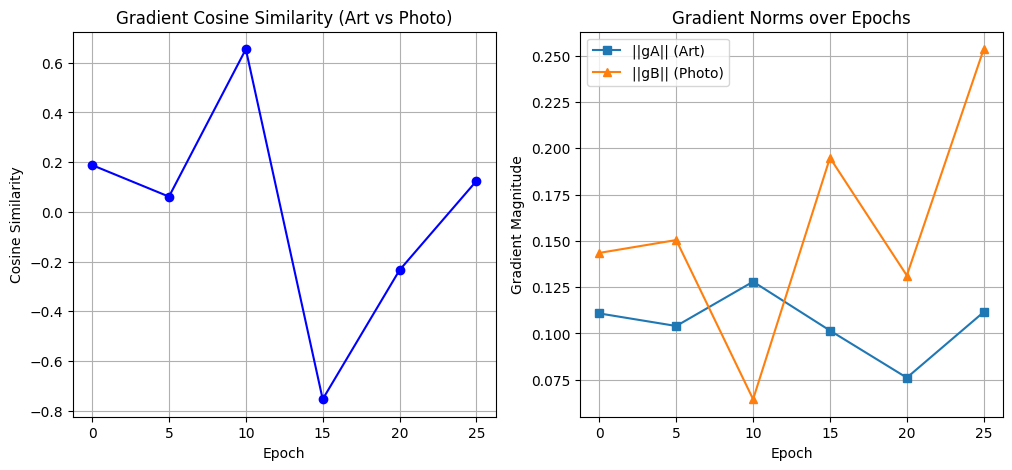


🧭 Gradient Conflict Analysis Summary:
Epoch 00: similarity=0.188 → ⚖️ Partial alignment (minor conflict)
Epoch 05: similarity=0.061 → ⚖️ Partial alignment (minor conflict)
Epoch 10: similarity=0.654 → ✅ Strong alignment (domains agree)
Epoch 15: similarity=-0.754 → ❌ Severe conflict (opposite gradients)
Epoch 20: similarity=-0.234 → ⚠️ Moderate conflict (partial opposition)
Epoch 25: similarity=0.124 → ⚖️ Partial alignment (minor conflict)


In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

# --- Domains for gradient analysis ---
loader_A = domain_loaders['art_painting']
loader_B = domain_loaders['photo']

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
prompt_learner = prompt_learner.to(device)

# --- Helper: Flattened gradient vector for prompt params ---
def get_grad_vector(model, prompt_learner, loss):
    grads = []
    model.zero_grad()
    prompt_learner.zero_grad()
    loss.backward(retain_graph=True)
    for name, param in prompt_learner.named_parameters():
        if param.grad is not None:
            grads.append(param.grad.detach().flatten())
    if grads:
        return torch.cat(grads)
    else:
        return torch.tensor([], device=device)

# --- Cosine similarity helper ---
def cosine_sim(g1, g2):
    if g1.numel() == 0 or g2.numel() == 0:
        return 0.0
    return F.cosine_similarity(g1.unsqueeze(0), g2.unsqueeze(0)).item()

# --- Training + Gradient Tracking ---
EPOCHS = 30
checkpoints = [0, 5, 10, 15, 20, 25, 30]
grad_sims, grad_norms_A, grad_norms_B = [], [], []

optimizer = torch.optim.Adam(list(prompt_learner.parameters()), lr=1e-4)

for epoch in range(EPOCHS):
    model.train()
    prompt_learner.train()
    total_loss = 0.0

    for (xA, yA), (xB, yB) in zip(loader_A, loader_B):
        xA, yA = xA.to(device), yA.to(device)
        xB, yB = xB.to(device), yB.to(device)

        # --- Domain A forward ---
        with torch.no_grad():
            imgA = model.encode_image(xA).float()
            imgA = imgA / imgA.norm(dim=-1, keepdim=True)
        txt = prompt_learner().float()
        logits_A = 100.0 * imgA @ txt.T
        loss_A = F.cross_entropy(logits_A, yA)

        # --- Domain B forward ---
        with torch.no_grad():
            imgB = model.encode_image(xB).float()
            imgB = imgB / imgB.norm(dim=-1, keepdim=True)
        txt = prompt_learner().float()
        logits_B = 100.0 * imgB @ txt.T
        loss_B = F.cross_entropy(logits_B, yB)

        # --- Combined update ---
        loss = loss_A + loss_B
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # --- Gradient conflict analysis ---
    if epoch in checkpoints:
        model.eval()
        prompt_learner.eval()

        (xA, yA) = next(iter(loader_A))
        (xB, yB) = next(iter(loader_B))
        xA, yA = xA.to(device), yA.to(device)
        xB, yB = xB.to(device), yB.to(device)

        with torch.no_grad():
            imgA = model.encode_image(xA).float()
            imgA = imgA / imgA.norm(dim=-1, keepdim=True)
            imgB = model.encode_image(xB).float()
            imgB = imgB / imgB.norm(dim=-1, keepdim=True)

        txt = prompt_learner().float()
        logits_A = 100.0 * imgA @ txt.T
        logits_B = 100.0 * imgB @ txt.T

        loss_A = F.cross_entropy(logits_A, yA)
        loss_B = F.cross_entropy(logits_B, yB)

        # Compute gradients
        gA = get_grad_vector(model, prompt_learner, loss_A)
        gB = get_grad_vector(model, prompt_learner, loss_B)

        sim = cosine_sim(gA, gB)
        grad_sims.append((epoch, sim))
        grad_norms_A.append((epoch, gA.norm().item()))
        grad_norms_B.append((epoch, gB.norm().item()))

        print(f"Epoch {epoch}:")
        print(f"  Gradient Cosine Similarity = {sim:.4f}")
        print(f"  ||gA|| = {gA.norm().item():.4f}, ||gB|| = {gB.norm().item():.4f}\n")

# --- Plot similarity and gradient norms ---
epochs, sims = zip(*grad_sims)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, sims, marker='o', color='b')
plt.title("Gradient Cosine Similarity (Art vs Photo)")
plt.xlabel("Epoch")
plt.ylabel("Cosine Similarity")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(*zip(*grad_norms_A), label="||gA|| (Art)", marker='s')
plt.plot(*zip(*grad_norms_B), label="||gB|| (Photo)", marker='^')
plt.title("Gradient Norms over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Gradient Magnitude")
plt.legend()
plt.grid(True)
plt.show()

# --- Interpretation ---
print("\n🧭 Gradient Conflict Analysis Summary:")
for e, s in grad_sims:
    if s > 0.5:
        msg = "✅ Strong alignment (domains agree)"
    elif s > 0.0:
        msg = "⚖️ Partial alignment (minor conflict)"
    elif s > -0.5:
        msg = "⚠️ Moderate conflict (partial opposition)"
    else:
        msg = "❌ Severe conflict (opposite gradients)"
    print(f"Epoch {e:02d}: similarity={s:.3f} → {msg}")

# --- (Optional) Return gradient tensors for inspection ---
grad_data = {
    "epochs": epochs,
    "similarities": sims,
    "grad_norms_A": grad_norms_A,
    "grad_norms_B": grad_norms_B,
}

In [ ]:
# --- OPEN-SET PROMPT TUNING on PACS (CLIP ViT-B/32) - REDESIGNED ---
!pip install git+https://github.com/openai/CLIP.git --quiet
import torch, torch.nn as nn, torch.nn.functional as F, torchvision, numpy as np
import clip, os
from tqdm import tqdm
from sklearn.metrics import roc_curve, roc_auc_score
from collections import Counter

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

# --- Load CLIP ---
model, preprocess = clip.load("ViT-B/32", device=device)
model.eval(); model.float()

if not os.path.isdir('./Homework3-PACS'):
    !git clone https://github.com/MachineLearning2020/Homework3-PACS

# --- PACS paths ---
domains = {
    "photo": "Homework3-PACS/PACS/photo",
    "art_painting": "Homework3-PACS/PACS/art_painting",
    "cartoon": "Homework3-PACS/PACS/cartoon",
    "sketch": "Homework3-PACS/PACS/sketch"
}

# CHANGE 1: Use sketch as source (much harder for CLIP)
src_domain = "sketch"
tgt_domain = "photo"   # Target for domain shift analysis

dataset_src = torchvision.datasets.ImageFolder(domains[src_domain], transform=preprocess)
dataset_tgt = torchvision.datasets.ImageFolder(domains[tgt_domain], transform=preprocess)
class_names = dataset_src.classes

NUM_CLASSES = len(class_names)
n_seen = int(NUM_CLASSES * 0.8)
seen_classes = class_names[:n_seen]
unseen_classes = class_names[n_seen:]

print(f"Source Domain: {src_domain}")
print(f"Target Domain: {tgt_domain}")
print(f"Total classes: {NUM_CLASSES}")
print(f"Seen (80%): {seen_classes}")
print(f"Unseen (20%): {unseen_classes}")

# --- Split seen/unseen subsets ---
seen_idx = [i for i, (_, y) in enumerate(dataset_src.samples) if class_names[y] in seen_classes]
unseen_idx = [i for i, (_, y) in enumerate(dataset_src.samples) if class_names[y] in unseen_classes]
seen_subset = torch.utils.data.Subset(dataset_src, seen_idx)
unseen_subset = torch.utils.data.Subset(dataset_src, unseen_idx)

# CHANGE 2: Split train/val for seen classes
from sklearn.model_selection import train_test_split
train_seen_idx, val_seen_idx = train_test_split(seen_idx, train_size=0.8, random_state=42)
train_seen_subset = torch.utils.data.Subset(dataset_src, train_seen_idx)
val_seen_subset = torch.utils.data.Subset(dataset_src, val_seen_idx)

train_loader = torch.utils.data.DataLoader(train_seen_subset, batch_size=32, shuffle=True, num_workers=2)
val_seen_loader = torch.utils.data.DataLoader(val_seen_subset, batch_size=32, shuffle=False, num_workers=2)
unseen_loader = torch.utils.data.DataLoader(unseen_subset, batch_size=32, shuffle=False, num_workers=2)

print(f"Train seen samples: {len(train_seen_subset)}")
print(f"Val seen samples: {len(val_seen_subset)}")
print(f"Unseen samples: {len(unseen_subset)}")

# --- Prompt Learner ---
class PromptLearner(nn.Module):
    def __init__(self, classnames, clip_model, n_ctx=16):  # CHANGE 3: Increased context
        super().__init__()
        ctx_dim = clip_model.ln_final.weight.shape[0]
        self.context = nn.Parameter(torch.randn(n_ctx, ctx_dim) * 0.02)
        self.mlp = nn.Sequential(nn.Linear(ctx_dim, ctx_dim), nn.ReLU(), nn.Linear(ctx_dim, ctx_dim))
        self.classnames = classnames
        self.tokenized = torch.cat([clip.tokenize(f"a photo of a {c}") for c in classnames])
        self.clip_model = clip_model

    def forward_all(self):
        with torch.no_grad():
            base_text = self.clip_model.encode_text(self.tokenized.to(device)).float()
        ctx = self.mlp(self.context.mean(0, keepdim=True))
        feats = base_text + ctx
        feats = feats / feats.norm(dim=-1, keepdim=True)
        return feats

# --- Build zero-shot text features (BEFORE training) ---
with torch.no_grad():
    zero_text_feats = []
    for c in class_names:
        tok = clip.tokenize(f"a photo of a {c}").to(device)
        f = model.encode_text(tok).float()
        f = f / (f.norm(dim=-1, keepdim=True) + 1e-6)
        zero_text_feats.append(f)
    zero_text_feats = torch.cat(zero_text_feats, dim=0)

# --- Evaluate function ---
def evaluate(loader, text_feats, class_subset, all_class_names):
    preds, labels, msp, ent, logits_all = [], [], [], [], []
    with torch.no_grad():
        for imgs, labs in loader:
            imgs = imgs.to(device)
            img_feats = model.encode_image(imgs).float()
            img_feats = img_feats / (img_feats.norm(dim=-1, keepdim=True) + 1e-6)
            logits = 50 * img_feats @ text_feats.T
            probs = F.softmax(logits, dim=-1)
            confs, pred = probs.max(dim=1)
            e = -(probs * torch.log(probs + 1e-12)).sum(dim=1)

            labs_remapped = torch.tensor([
                class_subset.index(all_class_names[int(l)])
                for l in labs
            ])

            preds.append(pred.cpu())
            labels.append(labs_remapped)
            msp.append(confs.cpu())
            ent.append(e.cpu())
            logits_all.append(logits.cpu())

    return (torch.cat(preds), torch.cat(labels), torch.cat(msp),
            torch.cat(ent), torch.cat(logits_all, dim=0))

# ============================================================================
# BASELINE: Zero-Shot CLIP Evaluation
# ============================================================================
print("\n" + "="*70)
print("BASELINE: ZERO-SHOT CLIP")
print("="*70)

preds_seen_zero, labs_seen_zero, msp_seen_zero, ent_seen_zero, _ = \
    evaluate(val_seen_loader, zero_text_feats[:n_seen], seen_classes, class_names)
preds_unseen_zero, labs_unseen_zero, msp_unseen_zero, ent_unseen_zero, _ = \
    evaluate(unseen_loader, zero_text_feats[n_seen:], unseen_classes, class_names)

acc_seen_zero = (preds_seen_zero == labs_seen_zero).float().mean().item()
acc_unseen_zero = (preds_unseen_zero == labs_unseen_zero).float().mean().item()

print(f"\nSeen Classes:")
print(f"  Accuracy: {acc_seen_zero:.4f}")
print(f"  MSP: {msp_seen_zero.mean():.4f} (std: {msp_seen_zero.std():.4f})")
print(f"  Entropy: {ent_seen_zero.mean():.4f} (std: {ent_seen_zero.std():.4f})")

print(f"\nUnseen Classes:")
print(f"  Accuracy: {acc_unseen_zero:.4f}")
print(f"  MSP: {msp_unseen_zero.mean():.4f} (std: {msp_unseen_zero.std():.4f})")
print(f"  Entropy: {ent_unseen_zero.mean():.4f} (std: {ent_unseen_zero.std():.4f})")

# ============================================================================
# TRAIN: Prompt Tuning on SEEN classes only
# ============================================================================
print("\n" + "="*70)
print("TRAINING: PROMPT TUNING ON SEEN CLASSES")
print("="*70)

prompt_seen = PromptLearner(seen_classes, model).to(device)
opt = torch.optim.AdamW(prompt_seen.parameters(), lr=5e-4, weight_decay=1e-4)

epochs = 10  # CHANGE 4: More epochs for harder task
best_val_acc = 0

for ep in range(epochs):
    prompt_seen.train()
    total_loss = 0
    for imgs, labels in tqdm(train_loader, desc=f"Epoch {ep+1}/{epochs}"):
        imgs = imgs.to(device)
        labels = torch.tensor([seen_classes.index(class_names[int(l)]) for l in labels], device=device)
        with torch.no_grad():
            img_feats = model.encode_image(imgs).float()
        img_feats = img_feats / (img_feats.norm(dim=-1, keepdim=True) + 1e-6)
        text_feats = prompt_seen.forward_all()
        logits = 50 * img_feats @ text_feats.T
        loss = F.cross_entropy(logits, labels)
        if torch.isnan(loss): continue
        opt.zero_grad(); loss.backward()
        torch.nn.utils.clip_grad_norm_(prompt_seen.parameters(), 1.0)
        opt.step()
        total_loss += loss.item()

    # Validation
    prompt_seen.eval()
    with torch.no_grad():
        tuned_text_feats = prompt_seen.forward_all()
    preds_val, labs_val, _, _, _ = evaluate(val_seen_loader, tuned_text_feats, seen_classes, class_names)
    val_acc = (preds_val == labs_val).float().mean().item()

    print(f"Epoch {ep+1}: loss={total_loss/len(train_loader):.4f}, val_acc={val_acc:.4f}")
    best_val_acc = max(best_val_acc, val_acc)

# ============================================================================
# ANALYSIS 1: Open-Set Recognition Performance
# ============================================================================
print("\n" + "="*70)
print("ANALYSIS 1: OPEN-SET RECOGNITION")
print("="*70)

prompt_seen.eval()
with torch.no_grad():
    tuned_text_feats = prompt_seen.forward_all()

# Evaluate tuned prompts on seen classes
preds_seen_tuned, labs_seen_tuned, msp_seen_tuned, ent_seen_tuned, _ = \
    evaluate(val_seen_loader, tuned_text_feats, seen_classes, class_names)
acc_seen_tuned = (preds_seen_tuned == labs_seen_tuned).float().mean().item()

print(f"\n📊 Prompt-Tuned on SEEN Classes:")
print(f"  Accuracy: {acc_seen_tuned:.4f} (baseline: {acc_seen_zero:.4f}, Δ{acc_seen_tuned-acc_seen_zero:+.4f})")
print(f"  MSP: {msp_seen_tuned.mean():.4f} (baseline: {msp_seen_zero.mean():.4f})")
print(f"  Entropy: {ent_seen_tuned.mean():.4f} (baseline: {ent_seen_zero.mean():.4f})")

# CRITICAL: Evaluate on UNSEEN classes with FULL class set (realistic scenario)
text_feats_hybrid = torch.cat([tuned_text_feats, zero_text_feats[n_seen:]], dim=0)

preds_unseen_hybrid, labs_unseen_hybrid, msp_unseen_hybrid, ent_unseen_hybrid, logits_unseen = \
    evaluate(unseen_loader, text_feats_hybrid, class_names, class_names)
acc_unseen_hybrid = (preds_unseen_hybrid == labs_unseen_hybrid).float().mean().item()

print(f"\n📊 Hybrid Model on UNSEEN Classes:")
print(f"  Accuracy: {acc_unseen_hybrid:.4f} (baseline: {acc_unseen_zero:.4f}, Δ{acc_unseen_hybrid-acc_unseen_zero:+.4f})")
print(f"  MSP: {msp_unseen_hybrid.mean():.4f} (baseline: {msp_unseen_zero.mean():.4f})")
print(f"  Entropy: {ent_unseen_hybrid.mean():.4f} (baseline: {ent_unseen_zero.mean():.4f})")

# Analyze misclassifications
incorrect_mask = preds_unseen_hybrid != labs_unseen_hybrid
if incorrect_mask.sum() > 0:
    misclassified_preds = preds_unseen_hybrid[incorrect_mask]
    print(f"\n  ⚠️  {incorrect_mask.sum()} misclassifications on unseen classes")
    print(f"  Where are they mapped?")
    pred_counts = Counter(misclassified_preds.numpy())
    for pred_idx, count in pred_counts.most_common():
        print(f"    → {class_names[pred_idx]}: {count} samples")

# ============================================================================
# ANALYSIS 2: OOD Detection - "Arbitrary High Scores" Hypothesis
# ============================================================================
print("\n" + "="*70)
print("ANALYSIS 2: OUT-OF-DISTRIBUTION DETECTION")
print("="*70)

# Force unseen samples through CLOSED-SET tuned prompts (no unseen classes)
with torch.no_grad():
    msp_unseen_closed, ent_unseen_closed, preds_unseen_closed = [], [], []
    for imgs, _ in unseen_loader:
        imgs = imgs.to(device)
        img_feats = model.encode_image(imgs).float()
        img_feats = img_feats / (img_feats.norm(dim=-1, keepdim=True) + 1e-6)
        logits = 50 * img_feats @ tuned_text_feats.T
        probs = F.softmax(logits, dim=-1)
        confs, pred = probs.max(dim=1)
        e = -(probs * torch.log(probs + 1e-12)).sum(dim=1)
        msp_unseen_closed.append(confs.cpu())
        ent_unseen_closed.append(e.cpu())
        preds_unseen_closed.append(pred.cpu())

    msp_unseen_closed = torch.cat(msp_unseen_closed)
    ent_unseen_closed = torch.cat(ent_unseen_closed)
    preds_unseen_closed = torch.cat(preds_unseen_closed)

print(f"\n🔍 Testing Hypothesis: 'Tuned prompts give arbitrary high scores to OOD'")
print(f"\nConfidence on Closed-Set Classifier:")
print(f"  Seen samples MSP: {msp_seen_tuned.mean():.4f} ± {msp_seen_tuned.std():.4f}")
print(f"  Unseen samples MSP: {msp_unseen_closed.mean():.4f} ± {msp_unseen_closed.std():.4f}")
print(f"  Confidence gap: {msp_seen_tuned.mean() - msp_unseen_closed.mean():.4f}")

if msp_unseen_closed.mean() > 0.7:
    print(f"  ⚠️  HIGH confidence on OOD! Hypothesis CONFIRMED.")
    print(f"     Model is overconfident on out-of-distribution samples.")
else:
    print(f"  ✅ Lower confidence on OOD. Model shows some uncertainty.")

print(f"\nUncertainty (Entropy):")
print(f"  Seen samples: {ent_seen_tuned.mean():.4f} ± {ent_seen_tuned.std():.4f}")
print(f"  Unseen samples: {ent_unseen_closed.mean():.4f} ± {ent_unseen_closed.std():.4f}")
print(f"  Entropy ratio: {ent_unseen_closed.mean() / ent_seen_tuned.mean():.2f}x")

# OOD Detection Metrics
labels_ood = np.concatenate([
    np.zeros(len(msp_seen_tuned)),  # seen = in-distribution
    np.ones(len(msp_unseen_closed))   # unseen = OOD
])

scores_msp = np.concatenate([1 - msp_seen_tuned.numpy(), 1 - msp_unseen_closed.numpy()])
scores_ent = np.concatenate([ent_seen_tuned.numpy(), ent_unseen_closed.numpy()])

fpr_msp, tpr_msp, thresholds_msp = roc_curve(labels_ood, scores_msp)
fpr95_msp = fpr_msp[np.argmin(np.abs(tpr_msp - 0.95))]
auroc_msp = roc_auc_score(labels_ood, scores_msp)

fpr_ent, tpr_ent, thresholds_ent = roc_curve(labels_ood, scores_ent)
fpr95_ent = fpr_ent[np.argmin(np.abs(tpr_ent - 0.95))]
auroc_ent = roc_auc_score(labels_ood, scores_ent)

print(f"\n📊 OOD Detection Performance:")
print(f"  MSP-based: AUROC={auroc_msp:.4f}, FPR@95TPR={fpr95_msp:.4f}")
print(f"  Entropy-based: AUROC={auroc_ent:.4f}, FPR@95TPR={fpr95_ent:.4f}")
print(f"  Better method: {'Entropy' if auroc_ent > auroc_msp else 'MSP'}")

# ============================================================================
# ANALYSIS 3: Prompt Embedding Similarity
# ============================================================================
print("\n" + "="*70)
print("ANALYSIS 3: PROMPT EMBEDDING SIMILARITY")
print("="*70)

with torch.no_grad():
    tuned_embeds = tuned_text_feats
    zero_embeds_seen = zero_text_feats[:n_seen]

    similarities = []
    print(f"\nCosine Similarity (Tuned vs Zero-Shot) for each class:")
    for i, cls in enumerate(seen_classes):
        sim = F.cosine_similarity(tuned_embeds[i:i+1], zero_embeds_seen[i:i+1], dim=-1).item()
        similarities.append(sim)
        print(f"  {cls:15s}: {sim:.4f}")

    avg_sim = np.mean(similarities)
    std_sim = np.std(similarities)

    print(f"\n  Average: {avg_sim:.4f} ± {std_sim:.4f}")

    if avg_sim > 0.95:
        print(f"  ✅ HIGH similarity - prompts stayed close to zero-shot")
        print(f"     → Minimal adaptation, preserving open-vocabulary")
    elif avg_sim > 0.85:
        print(f"  ➡️  MODERATE similarity - balanced adaptation")
        print(f"     → Some specialization while maintaining generalization")
    else:
        print(f"  ⚠️  LOW similarity - prompts drifted significantly")
        print(f"     → Strong specialization, may hurt open-set performance")

# ============================================================================
# ANALYSIS 4: Cross-Domain Prompt Similarity
# ============================================================================
print("\n" + "="*70)
print("ANALYSIS 4: DOMAIN SHIFT - FEW-SHOT TARGET TUNING")
print("="*70)

# Create few-shot target dataset (5 samples per class)
tgt_seen_idx = [i for i, (_, y) in enumerate(dataset_tgt.samples) if class_names[y] in seen_classes]
from collections import defaultdict
class_to_idx = defaultdict(list)
for idx in tgt_seen_idx:
    _, label = dataset_tgt.samples[idx]
    class_to_idx[label].append(idx)

few_shot_idx = []
shots = 5
for label in range(n_seen):
    few_shot_idx.extend(class_to_idx[label][:shots])

few_shot_subset = torch.utils.data.Subset(dataset_tgt, few_shot_idx)
few_shot_loader = torch.utils.data.DataLoader(few_shot_subset, batch_size=16, shuffle=True, num_workers=2)

print(f"\nFew-shot tuning on TARGET domain ({tgt_domain}):")
print(f"  {shots} shots per class × {n_seen} classes = {len(few_shot_subset)} samples")

# Train target prompt
prompt_tgt = PromptLearner(seen_classes, model).to(device)
opt_tgt = torch.optim.AdamW(prompt_tgt.parameters(), lr=5e-4, weight_decay=1e-4)

for ep in range(15):  # More epochs for few-shot
    prompt_tgt.train()
    total_loss = 0
    for imgs, labels in few_shot_loader:
        imgs = imgs.to(device)
        labels = torch.tensor([seen_classes.index(class_names[int(l)]) for l in labels], device=device)
        with torch.no_grad():
            img_feats = model.encode_image(imgs).float()
        img_feats = img_feats / (img_feats.norm(dim=-1, keepdim=True) + 1e-6)
        text_feats = prompt_tgt.forward_all()
        logits = 50 * img_feats @ text_feats.T
        loss = F.cross_entropy(logits, labels)
        if torch.isnan(loss): continue
        opt_tgt.zero_grad(); loss.backward()
        torch.nn.utils.clip_grad_norm_(prompt_tgt.parameters(), 1.0)
        opt_tgt.step()
        total_loss += loss.item()
    if (ep + 1) % 5 == 0:
        print(f"  Epoch {ep+1}: loss={total_loss/len(few_shot_loader):.4f}")

# Compare source vs target prompts
prompt_tgt.eval()
with torch.no_grad():
    tgt_text_feats = prompt_tgt.forward_all()
    src_text_feats = tuned_text_feats

    print(f"\n📊 Cross-Domain Prompt Comparison:")
    print(f"  Source: {src_domain}, Target: {tgt_domain}")
    print(f"\n  Per-class cosine similarity:")

    cross_similarities = []
    for i, cls in enumerate(seen_classes):
        sim = F.cosine_similarity(src_text_feats[i:i+1], tgt_text_feats[i:i+1], dim=-1).item()
        cross_similarities.append(sim)
        print(f"    {cls:15s}: {sim:.4f}")

    avg_cross_sim = np.mean(cross_similarities)
    std_cross_sim = np.std(cross_similarities)

    print(f"\n  Average cross-domain similarity: {avg_cross_sim:.4f} ± {std_cross_sim:.4f}")

    if avg_cross_sim > 0.90:
        print(f"  ✅ HIGH similarity across domains")
        print(f"     → Learned prompts are domain-invariant")
        print(f"     → Good generalization across visual styles")
    elif avg_cross_sim > 0.75:
        print(f"  ➡️  MODERATE similarity")
        print(f"     → Some domain-specific adaptation")
        print(f"     → Balance between specialization and transfer")
    else:
        print(f"  ⚠️  LOW similarity")
        print(f"     → Domain-specific prompts (large domain gap)")
        print(f"     → May indicate overfitting to domain characteristics")

# ============================================================================
# FINAL SUMMARY
# ============================================================================
print("\n" + "="*70)
print("FINAL SUMMARY")
print("="*70)

print(f"\n1️⃣  CLOSED-SET PERFORMANCE:")
print(f"   Seen classes: {acc_seen_zero:.4f} → {acc_seen_tuned:.4f} ({(acc_seen_tuned-acc_seen_zero)*100:+.1f}%)")

print(f"\n2️⃣  OPEN-SET GENERALIZATION:")
print(f"   Unseen classes: {acc_unseen_zero:.4f} → {acc_unseen_hybrid:.4f} ({(acc_unseen_hybrid-acc_unseen_zero)*100:+.1f}%)")
if acc_unseen_hybrid < acc_unseen_zero * 0.95:
    print(f"   ⚠️  Prompt tuning HURTS open-set recognition")
elif acc_unseen_hybrid > acc_unseen_zero * 1.05:
    print(f"   ✅ Prompt tuning HELPS open-set recognition")
else:
    print(f"   ➡️  Neutral impact on open-set")

print(f"\n3️⃣  OOD DETECTION:")
print(f"   Best AUROC: {max(auroc_msp, auroc_ent):.4f} ({'Entropy' if auroc_ent > auroc_msp else 'MSP'})")
print(f"   Confidence on OOD: {msp_unseen_closed.mean():.4f}")
if msp_unseen_closed.mean() > 0.7:
    print(f"   ⚠️  Overconfident on OOD samples - hypothesis confirmed")

print(f"\n4️⃣  PROMPT DRIFT:")
print(f"   Similarity to zero-shot: {avg_sim:.4f}")
print(f"   {'High drift' if avg_sim < 0.85 else 'Moderate drift' if avg_sim < 0.95 else 'Low drift'}")

print(f"\n5️⃣  DOMAIN TRANSFER:")
print(f"   Cross-domain similarity: {avg_cross_sim:.4f}")
print(f"   Domain gap: {'Large' if avg_cross_sim < 0.75 else 'Medium' if avg_cross_sim < 0.90 else 'Small'}")

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.1 MB/s eta 0:00:00
Device: cuda


100%|███████████████████████████████████████| 338M/338M [00:03<00:00, 90.6MiB/s]


Cloning into 'Homework3-PACS'...
remote: Enumerating objects: 10032, done.
remote: Total 10032 (delta 0), reused 0 (delta 0), pack-reused 10032 (from 1)
Receiving objects: 100% (10032/10032), 174.13 MiB | 31.61 MiB/s, done.
Resolving deltas: 100% (1/1), done.
Updating files: 100% (9993/9993), done.
Source Domain: sketch
Target Domain: photo
Total classes: 7
Seen (80%): ['dog', 'elephant', 'giraffe', 'guitar', 'horse']
Unseen (20%): ['house', 'person']
Train seen samples: 2951
Val seen samples: 738
Unseen samples: 240

BASELINE: ZERO-SHOT CLIP

Seen Classes:
  Accuracy: 0.8293
  MSP: 0.7487 (std: 0.1893)
  Entropy: 0.7255 (std: 0.3636)

Unseen Classes:
  Accuracy: 1.0000
  MSP: 0.9415 (std: 0.0487)
  Entropy: 0.2077 (std: 0.1004)

TRAINING: PROMPT TUNING ON SEEN CLASSES


Epoch 1/10: 100%|██████████| 93/93 [00:12<00:00,  7.47it/s]


Epoch 1: loss=0.3570, val_acc=0.9024


Epoch 2/10: 100%|██████████| 93/93 [00:11<00:00,  7.83it/s]


Epoch 2: loss=0.2759, val_acc=0.8997


Epoch 3/10: 100%|██████████| 93/93 [00:11<00:00,  7.98it/s]


Epoch 3: loss=0.2596, val_acc=0.9024


Epoch 4/10: 100%|██████████| 93/93 [00:11<00:00,  7.77it/s]


Epoch 4: loss=0.2607, val_acc=0.8957


Epoch 5/10: 100%|██████████| 93/93 [00:12<00:00,  7.51it/s]


Epoch 5: loss=0.2739, val_acc=0.9011


Epoch 6/10: 100%|██████████| 93/93 [00:11<00:00,  7.78it/s]


Epoch 6: loss=0.2619, val_acc=0.8970


Epoch 7/10: 100%|██████████| 93/93 [00:12<00:00,  7.62it/s]


Epoch 7: loss=0.2568, val_acc=0.9051


Epoch 8/10: 100%|██████████| 93/93 [00:12<00:00,  7.63it/s]


Epoch 8: loss=0.2557, val_acc=0.8997


Epoch 9/10: 100%|██████████| 93/93 [00:11<00:00,  7.78it/s]


Epoch 9: loss=0.2505, val_acc=0.8984


Epoch 10/10: 100%|██████████| 93/93 [00:12<00:00,  7.68it/s]


Epoch 10: loss=0.2551, val_acc=0.9011

ANALYSIS 1: OPEN-SET RECOGNITION

📊 Prompt-Tuned on SEEN Classes:
  Accuracy: 0.9011 (baseline: 0.8293, Δ+0.0718)
  MSP: 0.8772 (baseline: 0.7487)
  Entropy: 0.3512 (baseline: 0.7255)

📊 Hybrid Model on UNSEEN Classes:
  Accuracy: 0.6542 (baseline: 1.0000, Δ-0.3458)
  MSP: 0.5830 (baseline: 0.9415)
  Entropy: 1.1568 (baseline: 0.2077)

  ⚠️  83 misclassifications on unseen classes
  Where are they mapped?
    → giraffe: 41 samples
    → dog: 25 samples
    → guitar: 17 samples

ANALYSIS 2: OUT-OF-DISTRIBUTION DETECTION

🔍 Testing Hypothesis: 'Tuned prompts give arbitrary high scores to OOD'

Confidence on Closed-Set Classifier:
  Seen samples MSP: 0.8772 ± 0.1688
  Unseen samples MSP: 0.5537 ± 0.1456
  Confidence gap: 0.3236
  ✅ Lower confidence on OOD. Model shows some uncertainty.

Uncertainty (Entropy):
  Seen samples: 0.3512 ± 0.3794
  Unseen samples: 1.1531 ± 0.2470
  Entropy ratio: 3.28x

📊 OOD Detection Performance:
  MSP-based: AUROC=0.905